## Setup

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
plt.style.use('seaborn-v0_8')

In [2]:
from sklearn.metrics import precision_score, recall_score, make_scorer, roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, log_loss, f1_score

In [3]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html

In [4]:
from utils import aif_test, aif_plot

In [5]:
X_train_f = pd.read_csv("./output/X_train_f.csv")
X_train_s = pd.read_csv("./output/X_train_s.csv")

X_test_f = pd.read_csv("./output/X_test_f.csv")
X_test_s = pd.read_csv("./output/X_test_s.csv")
y_test = pd.read_csv("./output/y_test.csv")

preds_test = pd.read_csv("./output/preds_test.csv")

# 00 Add rule-based predictions

In [10]:
preds_test['skill_rule'] = np.where((X_test_s['maxausbildung_imp2'] == 0) & 
                                    (X_test_s['maxausbildung_imp3'] == 0) & 
                                    (X_test_s['maxausbildung_imp4'] == 0) & 
                                    (X_test_s['maxausbildung_imp5'] == 0) & 
                                    (X_test_s['maxausbildung_imp6'] == 0) &
                                    (X_test_s['maxausbildung_imp.Missing.'] == 0), 1, 0)
preds_test['skill_rule'].describe()

count    89710.000000
mean         0.162680
std          0.369075
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: skill_rule, dtype: float64

In [11]:
preds_test['time_rule'] = np.where((X_test_s['seeking1_tot_dur'] > 730), 1, 0)
preds_test['time_rule'].describe()

count    89710.000000
mean         0.331457
std          0.470740
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: time_rule, dtype: float64

## 01a Overall Performance (w. protected attributes)

In [12]:
fpr1, tpr1, thresholds1 = roc_curve(preds_test['y_test'], preds_test['glm1_p'])

In [13]:
rocauc_glm1 = auc(fpr1, tpr1)

In [14]:
prec1, rec1, thresholds1 = precision_recall_curve(preds_test['y_test'], preds_test['glm1_p'])

In [15]:
prauc_glm1 = auc(rec1, prec1)

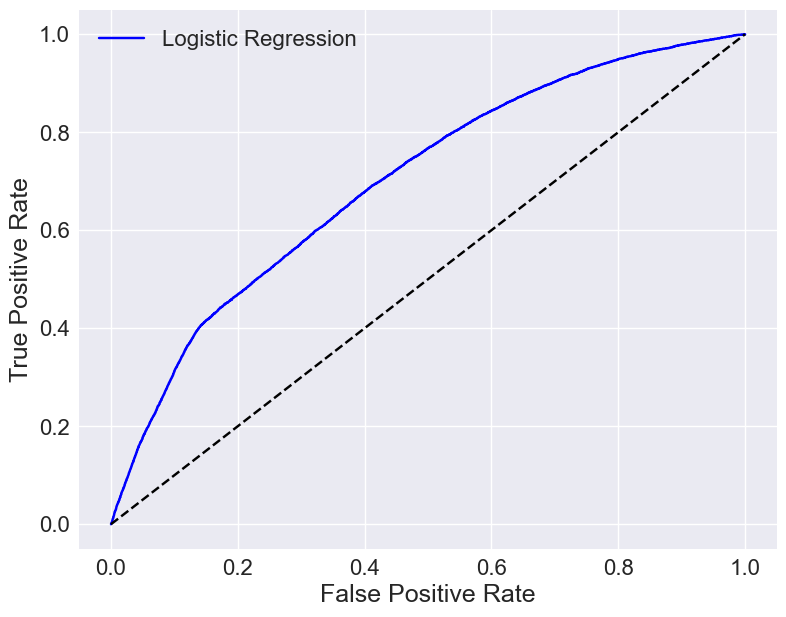

In [16]:
# ROC curves
random_probs = [0 for i in range(len(preds_test['y_test']))]
p_fpr, p_tpr, _ = roc_curve(preds_test['y_test'], random_probs, pos_label = 1)

fig, ax = plt.subplots(figsize = (9, 7))
plt.plot(fpr1, tpr1, color = 'blue', label = 'Logistic Regression')
#plt.plot(fpr2, tpr2, color = 'green', label = 'Elastic Net')
#plt.plot(fpr3, tpr3, color = 'orange', label = 'Random Forest')
#plt.plot(fpr4, tpr4, color = 'red', label = 'Gradient Boosting')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'black')
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.legend(loc = 'best', fontsize = 16)
plt.savefig('./output/ROC1', dpi = 300)
plt.show();

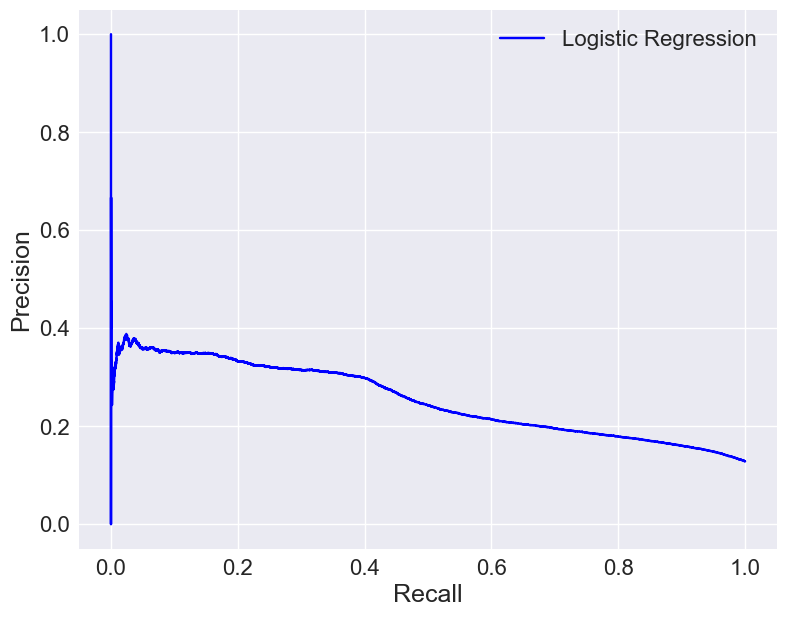

In [17]:
# PR curves
fig, ax = plt.subplots(figsize = (9, 7))
plt.plot(rec1, prec1, color = 'blue', label = 'Logistic Regression')
#plt.plot(rec2, prec2, color = 'green', label = 'Elastic Net')
#plt.plot(rec3, prec3, color = 'orange', label = 'Random Forest')
#plt.plot(rec4, prec4, color = 'red', label = 'Gradient Boosting')
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.xlabel('Recall', fontsize = 18)
plt.ylabel('Precision', fontsize = 18)
plt.legend(loc = 'best', fontsize = 16)
plt.savefig('./output/PR1', dpi = 300)
plt.show();

# 02 Classification Performance (rule-based predictions)

In [18]:
srule_rep = classification_report(preds_test['y_test'], preds_test['skill_rule'], output_dict = True)
srule_perf = pd.DataFrame(np.array([srule_rep['accuracy'], srule_rep['1']['f1-score'], srule_rep['1']['precision'], srule_rep['1']['recall']]), columns = ['skill_rule'])

In [19]:
trule_rep = classification_report(preds_test['y_test'], preds_test['time_rule'], output_dict = True)
trule_perf = pd.DataFrame(np.array([trule_rep['accuracy'], trule_rep['1']['f1-score'], trule_rep['1']['precision'], trule_rep['1']['recall']]), columns = ['time_rule'])

In [20]:
perf0 = pd.concat([srule_perf,
                   trule_perf], 
                  axis = 1).transpose()

In [21]:
perf0 = perf0.rename(columns={0: "Accuracy", 1: "F1 Score", 2: "Precision", 3: "Recall"})

In [22]:
perf0.to_latex('./output/test_perf0.tex', index = False, float_format = "%.3f")

# 02a Classification Performance (w. protected attributes)

In [23]:
glm1_c1_rep = classification_report(preds_test['y_test'], preds_test['glm1_c1'], output_dict = True)
glm1_c1_acc = balanced_accuracy_score(preds_test['y_test'], preds_test['glm1_c1'])
glm1_c1_perf = pd.DataFrame(np.array([rocauc_glm1, prauc_glm1, glm1_c1_rep['accuracy'], glm1_c1_acc, glm1_c1_rep['1']['f1-score'], glm1_c1_rep['1']['precision'], glm1_c1_rep['1']['recall']]), columns = ['glm1_c1'])

In [24]:
glm1_c2_rep = classification_report(preds_test['y_test'], preds_test['glm1_c2'], output_dict = True)
glm1_c2_acc = balanced_accuracy_score(preds_test['y_test'], preds_test['glm1_c2'])
glm1_c2_perf = pd.DataFrame(np.array([rocauc_glm1, prauc_glm1, glm1_c2_rep['accuracy'], glm1_c2_acc, glm1_c2_rep['1']['f1-score'], glm1_c2_rep['1']['precision'], glm1_c2_rep['1']['recall']]), columns = ['glm1_c2'])

In [26]:
perf1_1 = pd.concat([glm1_c1_perf,
                     #net1_c1_perf,
                     #rf1_c1_perf,
                     #gbm1_c1_perf
                     ], 
                    axis = 1).transpose()

In [27]:
perf1_1 = perf1_1.rename(columns={0: "ROC-AUC", 1: "PR-AUC", 2: "Accuracy", 3: "Balanced Accuracy", 4: "F1 Score", 5: "Precision", 6: "Recall"})

In [28]:
perf1_1.to_latex('./output/test_perf1_c1.tex', index = False, float_format = "%.3f")

In [29]:
perf1_2 = pd.concat([glm1_c2_perf,
                     #net1_c2_perf,
                     #rf1_c2_perf,
                     #gbm1_c2_perf
                     ], 
                    axis = 1).transpose()

In [30]:
perf1_2 = perf1_2.rename(columns={0: "ROC-AUC", 1: "PR-AUC", 2: "Accuracy", 3: "Balanced Accuracy", 4: "F1 Score", 5: "Precision", 6: "Recall"})

In [31]:
perf1_2.to_latex('./output/test_perf1_c2.tex', index = False, float_format = "%.3f")

# 03 Classification Performance by Groups

In [32]:
comb_test = pd.concat([preds_test, X_test_f], axis = 1)

In [33]:
comb_test['nongerman'] = np.where(comb_test['maxdeutsch1'] == 0, 1, 0)
comb_test.loc[comb_test['maxdeutsch.Missing.'] == 1, 'nongerman'] = np.nan
comb_test['nongerman_male'] = np.where((comb_test['nongerman'] == 1) & (comb_test['frau1'] == 0), 1, 0)
comb_test['nongerman_female'] = np.where((comb_test['nongerman'] == 1) & (comb_test['frau1'] == 1), 1, 0)

In [34]:
comb_test = comb_test.dropna()

In [35]:
f1 = []
pops = ('frau1', 'nongerman', 'nongerman_male', 'nongerman_female')

In [36]:
f1.append(['Overall',
           f1_score(comb_test['y_test'], comb_test['glm1_c1']), 
           f1_score(comb_test['y_test'], comb_test['glm1_c2']),
           #f1_score(comb_test['y_test'], comb_test['glm2_c1']),
           #f1_score(comb_test['y_test'], comb_test['glm2_c2']),
           #f1_score(comb_test['y_test'], comb_test['glm1b_c1']), 
           #f1_score(comb_test['y_test'], comb_test['glm1b_c2']),
           #f1_score(comb_test['y_test'], comb_test['glm2b_c1']), 
           #f1_score(comb_test['y_test'], comb_test['glm2b_c2']),
           #f1_score(comb_test['y_test'], comb_test['net1_c1']), 
           #f1_score(comb_test['y_test'], comb_test['net1_c2']),
           #f1_score(comb_test['y_test'], comb_test['net2_c1']), 
           #f1_score(comb_test['y_test'], comb_test['net2_c2']),
           #f1_score(comb_test['y_test'], comb_test['net1b_c1']), 
           #f1_score(comb_test['y_test'], comb_test['net1b_c2']),
           #f1_score(comb_test['y_test'], comb_test['net2b_c1']), 
           #f1_score(comb_test['y_test'], comb_test['net2b_c2']),
           #f1_score(comb_test['y_test'], comb_test['rf1_c1']), 
           #f1_score(comb_test['y_test'], comb_test['rf1_c2']),
           #f1_score(comb_test['y_test'], comb_test['rf2_c1']), 
           #f1_score(comb_test['y_test'], comb_test['rf2_c2']),
           #f1_score(comb_test['y_test'], comb_test['rf1b_c1']), 
           #f1_score(comb_test['y_test'], comb_test['rf1b_c2']),
           #f1_score(comb_test['y_test'], comb_test['rf2b_c1']), 
           #f1_score(comb_test['y_test'], comb_test['rf2b_c2']),
           #f1_score(comb_test['y_test'], comb_test['gbm1_c1']), 
           #f1_score(comb_test['y_test'], comb_test['gbm1_c2']),
           #f1_score(comb_test['y_test'], comb_test['gbm2_c1']), 
           #f1_score(comb_test['y_test'], comb_test['gbm2_c2']),
           #f1_score(comb_test['y_test'], comb_test['gbm1b_c1']), 
           #f1_score(comb_test['y_test'], comb_test['gbm1b_c2']),
           #f1_score(comb_test['y_test'], comb_test['gbm2b_c1']), 
           #f1_score(comb_test['y_test'], comb_test['gbm2b_c2'])
          ])

In [37]:
for pop in pops: 
    subset = (comb_test[pop] == 1)
    f1.append([pop,
                f1_score(comb_test[subset]['y_test'], comb_test[subset]['glm1_c1']),
                f1_score(comb_test[subset]['y_test'], comb_test[subset]['glm1_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['glm2_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['glm2_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['glm1b_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['glm1b_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['glm2b_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['glm2b_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['net1_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['net1_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['net2_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['net2_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['net1b_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['net1b_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['net2b_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['net2b_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['rf1_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['rf1_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['rf2_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['rf2_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['rf1b_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['rf1b_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['rf2b_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['rf2b_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['gbm1_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['gbm1_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['gbm2_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['gbm2_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['gbm1b_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['gbm1b_c2']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['gbm2b_c1']),
                #f1_score(comb_test[subset]['y_test'], comb_test[subset]['gbm2b_c2'])
              ])

In [38]:
f1_group = pd.DataFrame(f1)

In [39]:
f1_group = f1_group.rename(columns={0: 'pop', 
                                    1: 'LR_1_c1', 2: 'LR_1_c2', 3: 'LR_2_c1', 4: 'LR_2_c2', 
                                    5: 'LR_1b_c1', 6: 'LR_1b_c2', 7: 'LR_2b_c1', 8: 'LR_2b_c2',
                                    9: 'PLR_1_c1', 10: 'PLR_1_c2', 11: 'PLR_2_c1', 12: 'PLR_2_c2', 
                                    13: 'PLR_1b_c1', 14: 'PLR_1b_c2', 15: 'PLR_2b_c1', 16: 'PLR_2b_c2',
                                    17: 'RF_1_c1', 18: 'RF_1_c2', 19: 'RF_2_c1', 20: 'RF_2_c2', 
                                    21: 'RF_1b_c1', 22: 'RF_1b_c2', 23: 'RF_2b_c1', 24: 'RF_2b_c2', 
                                    25: 'GBM_1_c1', 26: 'GBM_1_c2', 27: 'GBM_2_c1', 28: 'GBM_2_c2',
                                    29: 'GBM_1b_c1', 30: 'GBM_1b_c2', 31: 'GBM_2b_c1', 32: 'GBM_2b_c2'})
f1_group['pop'] = ['Overall', 'Female', 'Non-German', 'Non-Ger. M', 'Non-Ger. F']

In [40]:
f1_group_l1 = pd.wide_to_long(f1_group, stubnames=['LR', 'PLR', 'RF', 'GBM'], i=['pop'], j='model', sep='_', suffix='\w+')
f1_group_l1 = f1_group_l1.reset_index()
f1_group_l2 = f1_group_l1.melt(id_vars=['pop', 'model'], var_name='method')
f1_group_l2[['Type', 'Cutoff']] = f1_group_l2['model'].str.split("_", expand = True)

In [41]:
f1_group_l2.to_csv('./output/f1_group.csv', index = False)

In [42]:
acc = []

acc.append(['Overall',
            balanced_accuracy_score(comb_test['y_test'], comb_test['glm1_c1']),
            balanced_accuracy_score(comb_test['y_test'], comb_test['glm1_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['glm2_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['glm2_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['glm1b_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['glm1b_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['glm2b_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['glm2b_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['net1_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['net1_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['net2_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['net2_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['net1b_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['net1b_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['net2b_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['net2b_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['rf1_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['rf1_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['rf2_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['rf2_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['rf1b_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['rf1b_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['rf2b_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['rf2b_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['gbm1_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['gbm1_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['gbm2_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['gbm2_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['gbm1b_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['gbm1b_c2']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['gbm2b_c1']),
            #balanced_accuracy_score(comb_test['y_test'], comb_test['gbm2b_c2'])
          ])

In [43]:
for pop in pops: 
    subset = (comb_test[pop] == 1)
    acc.append([pop,
                balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['glm1_c1']),
                balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['glm1_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['glm2_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['glm2_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['glm1b_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['glm1b_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['glm2b_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['glm2b_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['net1_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['net1_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['net2_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['net2_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['net1b_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['net1b_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['net2b_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['net2b_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['rf1_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['rf1_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['rf2_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['rf2_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['rf1b_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['rf1b_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['rf2b_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['rf2b_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['gbm1_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['gbm1_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['gbm2_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['gbm2_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['gbm1b_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['gbm1b_c2']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['gbm2b_c1']),
                #balanced_accuracy_score(comb_test[subset]['y_test'], comb_test[subset]['gbm2b_c2'])
              ])

In [44]:
acc_group = pd.DataFrame(acc)

acc_group = acc_group.rename(columns={0: 'pop', 
                                      1: 'LR_1_c1', 2: 'LR_1_c2', 3: 'LR_2_c1', 4: 'LR_2_c2', 
                                      5: 'LR_1b_c1', 6: 'LR_1b_c2', 7: 'LR_2b_c1', 8: 'LR_2b_c2',
                                      9: 'PLR_1_c1', 10: 'PLR_1_c2', 11: 'PLR_2_c1', 12: 'PLR_2_c2', 
                                      13: 'PLR_1b_c1', 14: 'PLR_1b_c2', 15: 'PLR_2b_c1', 16: 'PLR_2b_c2',
                                      17: 'RF_1_c1', 18: 'RF_1_c2', 19: 'RF_2_c1', 20: 'RF_2_c2', 
                                      21: 'RF_1b_c1', 22: 'RF_1b_c2', 23: 'RF_2b_c1', 24: 'RF_2b_c2', 
                                      25: 'GBM_1_c1', 26: 'GBM_1_c2', 27: 'GBM_2_c1', 28: 'GBM_2_c2',
                                      29: 'GBM_1b_c1', 30: 'GBM_1b_c2', 31: 'GBM_2b_c1', 32: 'GBM_2b_c2'})
acc_group['pop'] = ['Overall', 'Female', 'Non-German', 'Non-Ger. M', 'Non-Ger. F']

In [45]:
acc_group_l1 = pd.wide_to_long(acc_group, stubnames=['LR', 'PLR', 'RF', 'GBM'], i=['pop'], j='model', sep='_', suffix='\w+')
acc_group_l1 = acc_group_l1.reset_index()
acc_group_l2 = acc_group_l1.melt(id_vars=['pop', 'model'], var_name='method')
acc_group_l2[['Type', 'Cutoff']] = acc_group_l2['model'].str.split("_", expand = True)

acc_group_l2.to_csv('./output/acc_group.csv', index = False)

# Plots

<Axes: xlabel='value', ylabel='pop'>

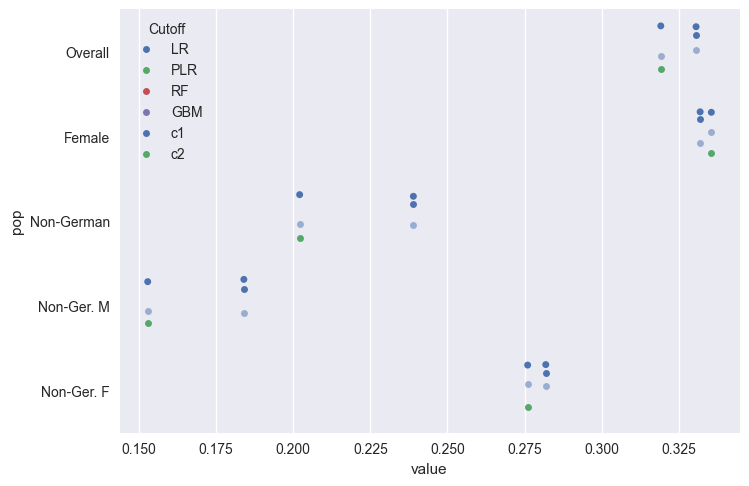

In [46]:
sns.stripplot(x = "value", y = "pop", data = f1_group_l2, alpha = .5, zorder = 1)
sns.stripplot(x = "value", y = "pop", hue = "method", dodge = True, data = f1_group_l2, zorder = 1)
sns.stripplot(x = "value", y = "pop", hue = "Cutoff", dodge = True, data = f1_group_l2, zorder = 1)

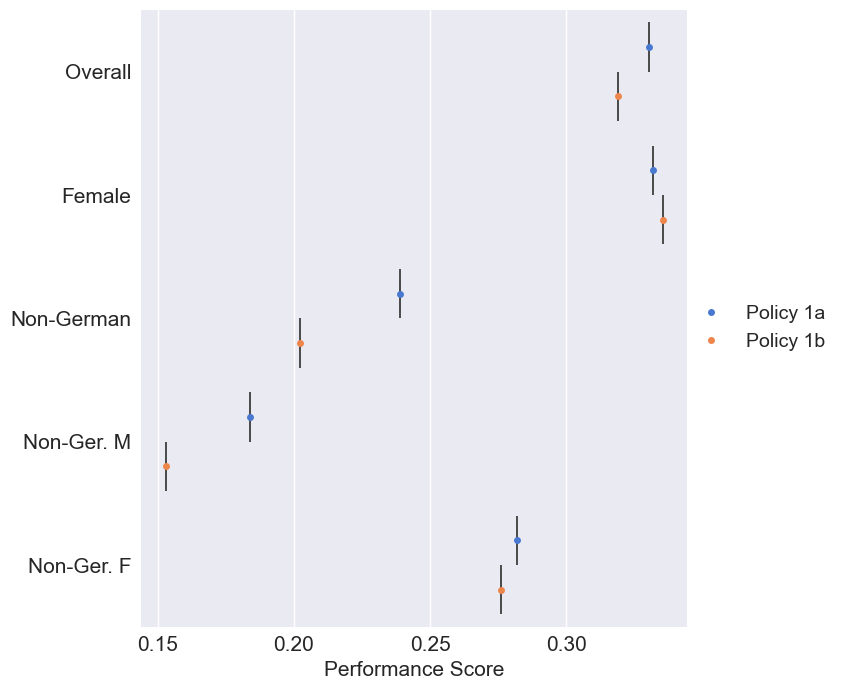

In [47]:
fig, ax1 = plt.subplots(figsize = (8.5, 7))
ax1 = sns.boxplot(x = "value", y = "pop", hue = "Cutoff", dodge = True, data = f1_group_l2, linewidth = 1.25, fliersize = 0)
ax1.xaxis.set_tick_params(labelsize = 15)
ax1.yaxis.set_tick_params(labelsize = 15)
ax2 = sns.stripplot(x = "value", y = "pop", hue = "Cutoff", dodge = True, data = f1_group_l2, palette = "muted")
ax2.set_xlabel("Performance Score", fontsize = 15)
ax2.set_ylabel("")
handles, labels = ax1.get_legend_handles_labels()
plt.legend(handles[2:4], ['Policy 1a', 'Policy 1b'], bbox_to_anchor = (0.975, 0.55), loc = 2, fontsize = 14)
plt.setp(ax1.artists, fill = False)
plt.tight_layout()
plt.savefig('./output/group_f1', dpi = 300)

<Axes: xlabel='value', ylabel='pop'>

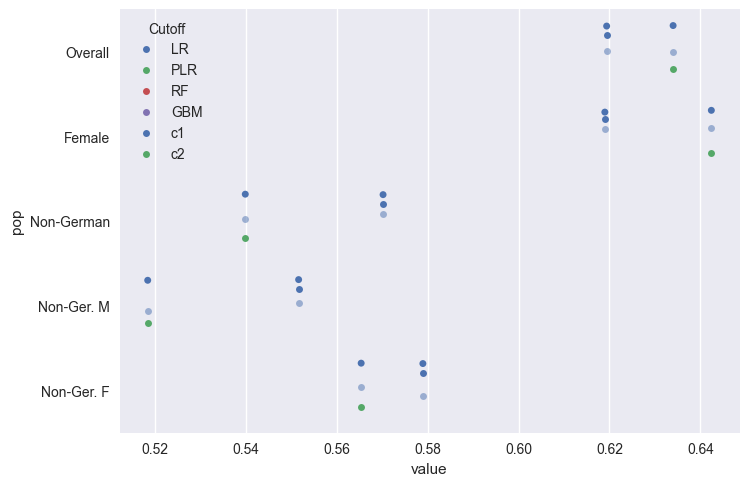

In [48]:
sns.stripplot(x = "value", y = "pop", data = acc_group_l2, alpha = .5, zorder = 1)
sns.stripplot(x = "value", y = "pop", hue = "method", dodge = True, data = acc_group_l2, zorder = 1)
sns.stripplot(x = "value", y = "pop", hue = "Cutoff", dodge = True, data = acc_group_l2, zorder = 1)

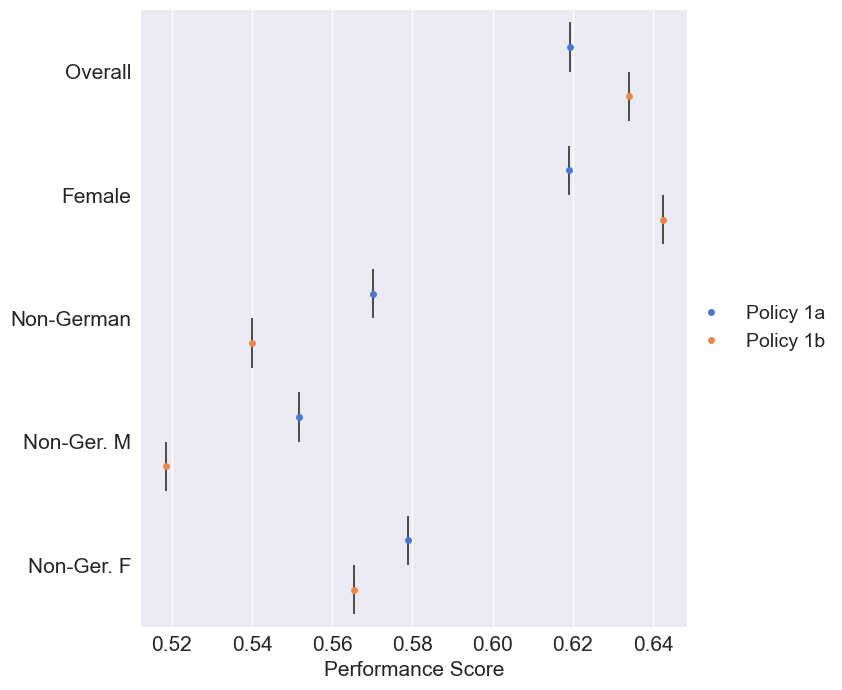

In [49]:
fig, ax1 = plt.subplots(figsize = (8.5, 7))
ax1 = sns.boxplot(x = "value", y = "pop", hue = "Cutoff", dodge = True, data = acc_group_l2, linewidth = 1.25, fliersize = 0)
ax1.xaxis.set_tick_params(labelsize = 15)
ax1.yaxis.set_tick_params(labelsize = 15)
ax2 = sns.stripplot(x = "value", y = "pop", hue = "Cutoff", dodge = True, data = acc_group_l2, palette = "muted")
ax2.set_xlabel("Performance Score", fontsize = 15)
ax2.set_ylabel("")
handles, labels = ax1.get_legend_handles_labels()
plt.legend(handles[2:4], ['Policy 1a', 'Policy 1b'], bbox_to_anchor = (0.975, 0.55), loc = 2, fontsize = 14)
plt.setp(ax1.artists, fill = False)
plt.tight_layout()
plt.savefig('./output/group_acc', dpi = 300)